In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pylab import rcParams
import plotly.graph_objects as go
import missingno as msno
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import scipy
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from pyod.models.ecod import ECOD

In [2]:
df = pd.read_csv('datasets/numerical_data.csv')

In [3]:
diseased_data = df[df['HeartDisease'] == 1]

# Feature Engineering

In [4]:
# 1. Ratio or Difference of Numerical Variables
diseased_data['HealthRatio'] = diseased_data['PhysicalHealth'] / diseased_data['MentalHealth'].replace(0, 1)  # Avoiding division by zero

/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_19899/3382140605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['HealthRatio'] = diseased_data['PhysicalHealth'] / diseased_data['MentalHealth'].replace(0, 1)  # Avoiding division by zero


In [5]:
# 2. Aggregating Binary Variables
diseased_data['LifestyleScore'] = diseased_data[['AlcoholDrinking', 'PhysicalActivity']].sum(axis=1)

/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_19899/2966631587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['LifestyleScore'] = diseased_data[['AlcoholDrinking', 'PhysicalActivity']].sum(axis=1)


In [6]:
# 3. Binning Age Category
age_bins = [0, 4, 8, 13, float('inf')]   # Bins for young adult, middle-aged, senior
age_labels = [1, 2, 3, 4] # 'young adult', 'middle-aged', 'senior', 'super-senior'
diseased_data['AgeGroup'] = pd.cut(diseased_data['AgeCategory'], bins=age_bins, labels=age_labels, right=False)

/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_19505/2793134395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['AgeGroup'] = pd.cut(diseased_data['AgeCategory'], bins=age_bins, labels=age_labels, right=False)


In [8]:
# 4. Binning BMI
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = [1, 2, 3, 4] # 'underweight', 'normal', 'overweight', 'obese'
diseased_data['BMICategory'] = pd.cut(diseased_data['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

/var/folders/kg/fftk_3yx6318lz6j3g83d5p80000gq/T/ipykernel_18766/1181913735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseased_data['BMICategory'] = pd.cut(diseased_data['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)


In [6]:
diseased_data.head()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI,HealthRatio,LifestyleScore
9,1.0,3.0,0.0,0.0,6.0,15.0,1.0,2,12.0,2.0,0.0,0.0,4.0,12.0,0.0,0.0,0.0,28.87,0.4,0.0
15,1.0,1.0,0.0,0.0,30.0,30.0,1.0,1,9.0,1.0,1.0,0.0,5.0,15.0,1.0,0.0,0.0,34.30,1.0,0.0
43,1.0,3.0,0.0,1.0,10.0,10.0,1.0,1,12.0,1.0,1.0,1.0,5.0,4.0,0.0,0.0,1.0,32.98,1.0,1.0
51,1.0,0.0,0.0,0.0,30.0,2.0,1.0,2,13.0,1.0,1.0,0.0,3.0,7.0,0.0,0.0,1.0,25.06,15.0,0.0
52,1.0,3.0,0.0,0.0,6.0,2.0,1.0,2,12.0,1.0,1.0,1.0,4.0,8.0,0.0,1.0,0.0,30.23,3.0,1.0


In [7]:
features_data = diseased_data[['HealthRatio', 'LifestyleScore', 'BMI']].copy()

In [8]:
features_data.head()

,HealthRatio,LifestyleScore,BMI
9,0.4,0.0,28.87
15,1.0,0.0,34.30
43,1.0,1.0,32.98
51,15.0,0.0,25.06
52,3.0,1.0,30.23


# Clustering

In [9]:
scaler = StandardScaler()

In [10]:
# Standardizing Features
columns = ['HealthRatio', 'LifestyleScore', 'BMI']

features_data[columns] = scaler.fit_transform(features_data[columns])

In [11]:
# KMeans and Elbow Method
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features_data[columns])
    inertia.append(kmeans.inertia_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

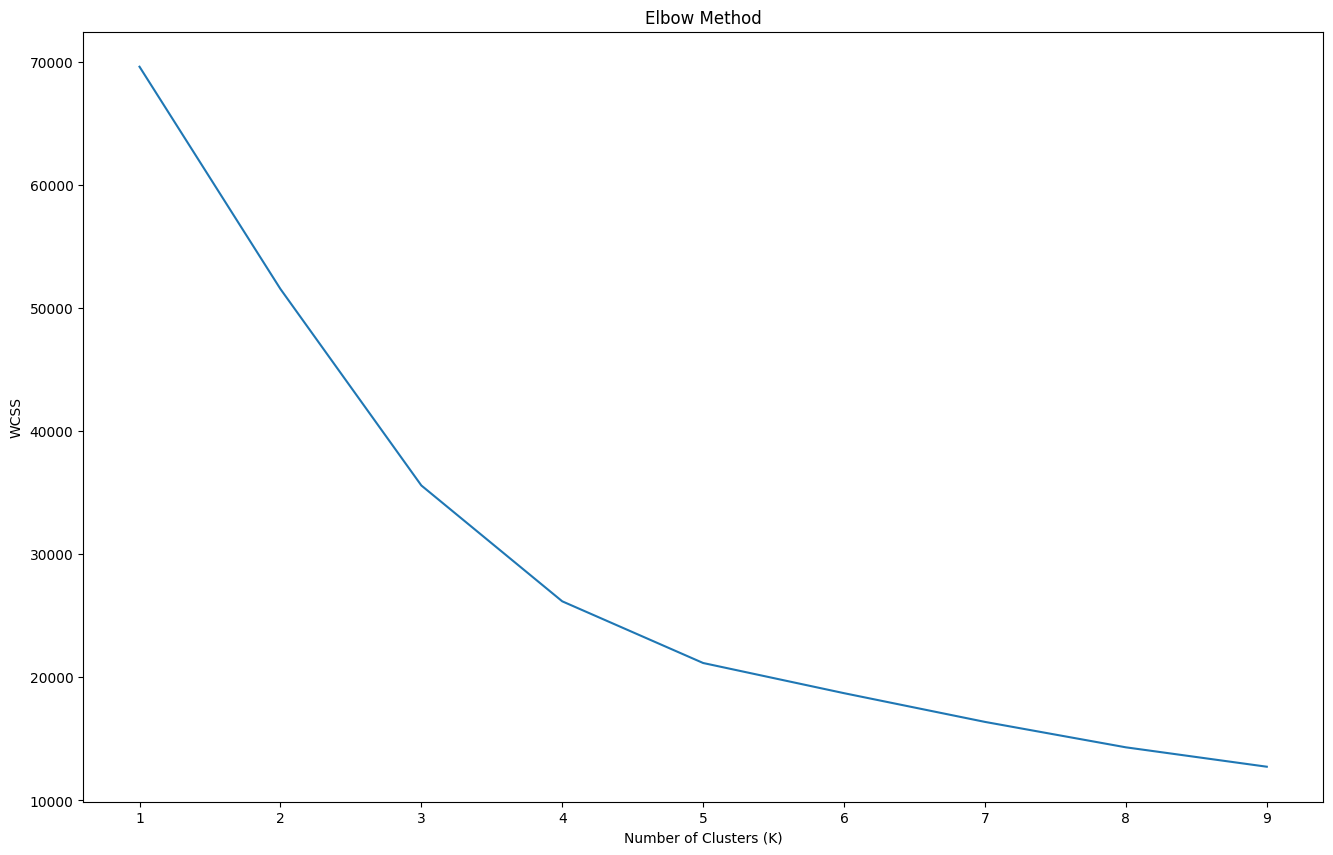

In [12]:
plt.figure(figsize=(16, 10))
plt.plot(range(1, 10), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

In [13]:
kmeans = KMeans(n_clusters=5)
features_data['Cluster'] = kmeans.fit_predict(features_data[columns])

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
features_data.head()

,HealthRatio,LifestyleScore,BMI,Cluster
9,-0.544347,-1.348477,-0.101309,1
15,-0.412431,-1.348477,0.673637,1
43,-0.412431,0.009304,0.485253,4
51,2.665607,-1.348477,-0.645056,3
52,0.027289,0.009304,0.092784,4


In [15]:
features_data.groupby('Cluster').mean()

,HealthRatio,LifestyleScore,BMI
Cluster,,,
0,-0.241903,1.367085,-0.239061
1,-0.297127,-1.348477,-0.245957
2,-0.245152,-0.463557,1.743775
3,2.728385,-0.028499,-0.088455
4,-0.310089,0.009304,-0.357009


# Plots

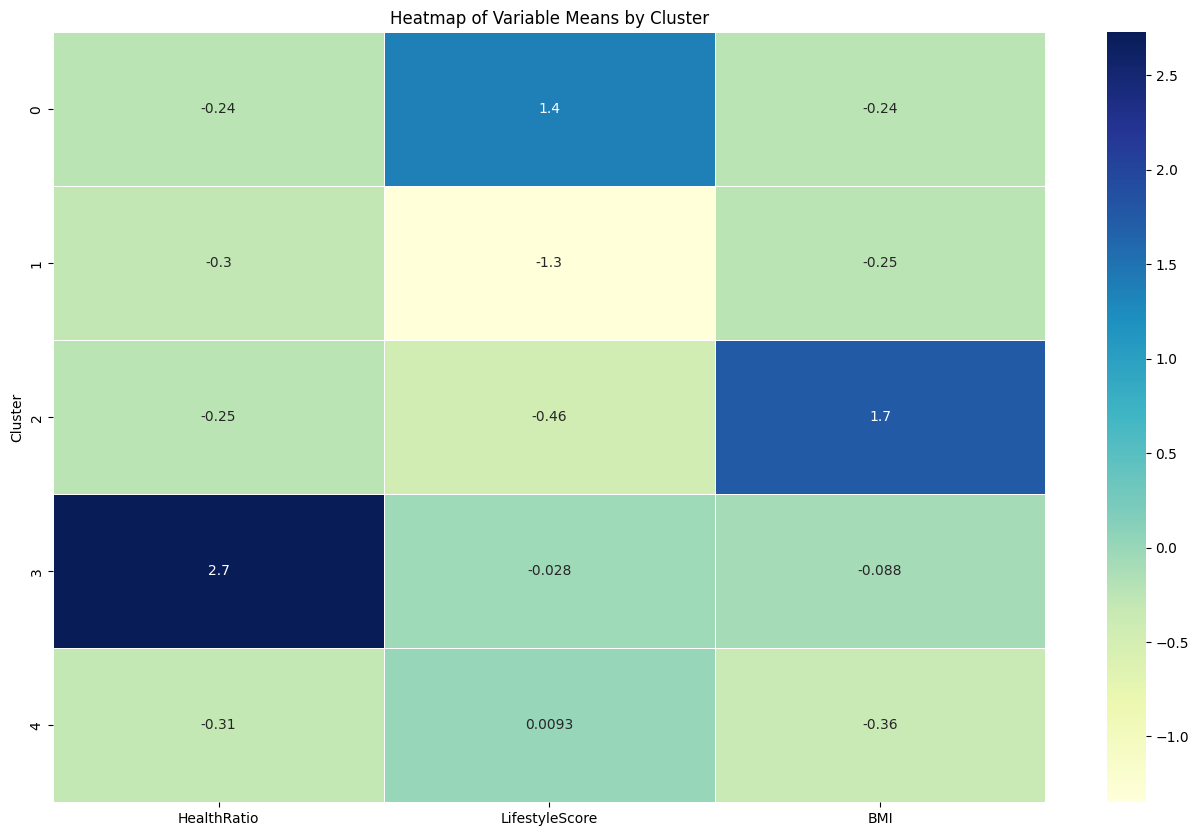

In [17]:
# Group the data by cluster and calculate the mean value for each variable within each cluster
cluster_means = features_data.groupby('Cluster').mean().reset_index()

# Set 'Cluster' as the index so it doesn't appear as a variable
cluster_means.set_index('Cluster', inplace=True)

# Create a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Variable Means by Cluster')
plt.show()

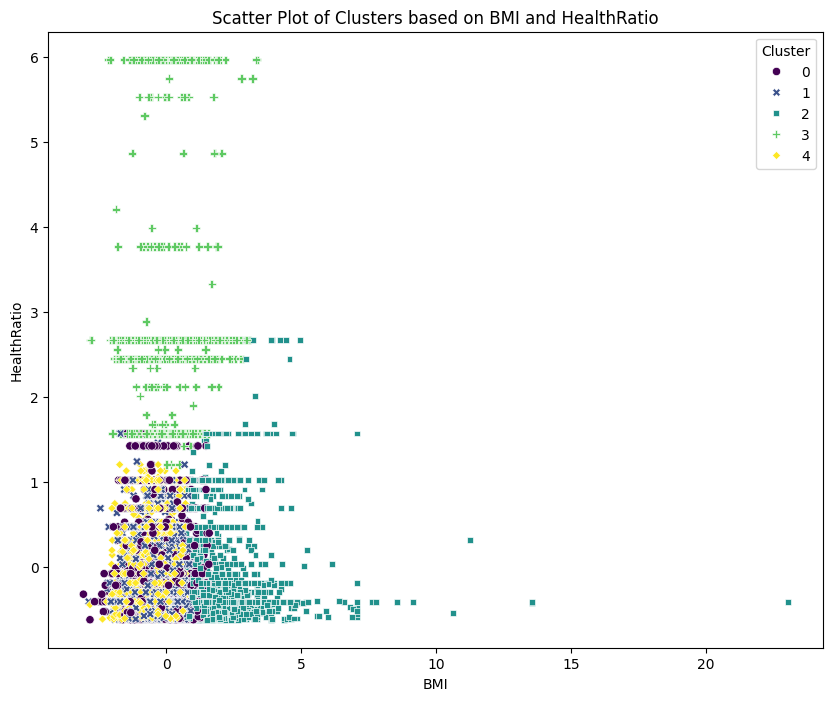

In [25]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=features_data, x='BMI', y='HealthRatio', hue='Cluster', palette='viridis', style='Cluster')
plt.title('Scatter Plot of Clusters based on BMI and HealthRatio')
plt.xlabel('BMI')
plt.ylabel('HealthRatio')
plt.legend(title='Cluster')
plt.show()

In [ ]:
columns = ['HealthRatio', 'LifestyleScore', 'AgeGroup', 'SleepTime', 'BMI']

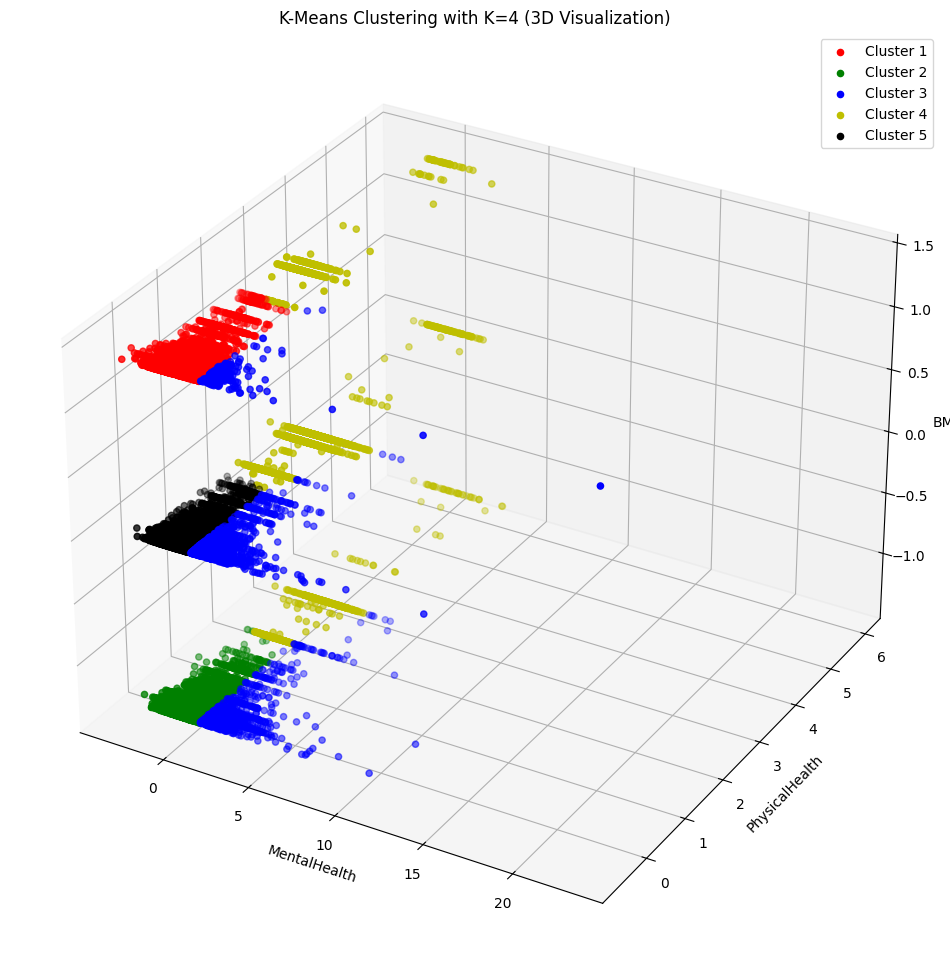

In [26]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b', 'y', 'k']

# Plot data points in 3D space
for cluster in range(5):
    cluster_data = features_data[features_data['Cluster'] == cluster]
    ax.scatter(cluster_data['BMI'], cluster_data['HealthRatio'], cluster_data['LifestyleScore'],
               c=colors[cluster], label=f'Cluster {cluster + 1}')

ax.set_xlabel('MentalHealth')
ax.set_ylabel('PhysicalHealth')
ax.set_zlabel('BMI')
ax.set_title(f'K-Means Clustering with K=4 (3D Visualization)')

plt.legend()
plt.show()

In [22]:
# Create a 3D scatter plot
fig = px.scatter_3d(features_data, x='LifestyleScore', y='HealthRatio', z='BMI', color='Cluster')

# Customize the plot
fig.update_layout(
    scene=dict(xaxis_title='LifestyleScore', yaxis_title='HealthRatio', zaxis_title='BMI'),
    scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),  # Adjust the initial camera view
    height=800,  # Set the height of the plot
    width=1000   # Set the width of the plot
)
fig.update_traces(marker=dict(size=5))

# Show the 3D plot
fig.show()